In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.interpolate import make_interp_spline
import matplotlib.ticker as ticker

PERCENT_CURRENT_CONTINENTAL_CRUST = 0.4

In [2]:
ensembles = list(range(1,199))

In [3]:
sio2_dict = {ensemble:{} for ensemble in ensembles}
n_impact_dict = {}
for ensemble in ensembles:
    for layer in range(12):
        with open("../data/IMPaCS/sio2_percent_tables/july2025/ensemble_{:d}_{:d}.csv".format(ensemble, layer), "r")as f:
            sio2_dict[ensemble][layer] = pd.read_csv(f).fillna(0)
    with open("../data/IMPaCS/impact_probabilities_export_july2025/ensemble_{:d}.csv".format(ensemble), "r")as f:
        n_impact_dict[ensemble] = pd.read_csv(f).fillna(0)

In [4]:
sio2_dict[ensemble]

{0:      Unnamed: 0         45         50         55         52         53  \
 0             0  79.079442  20.437466   0.483092   0.000000   0.000000   
 1             1  78.227322  20.383790   1.355341   0.033548   0.000000   
 2             2  76.878690  19.940955   1.435856   0.033548   1.710950   
 3             3  74.959742  21.833065   1.435856   0.060386   1.710950   
 4             4  74.778583  11.668009   0.254965  12.647611   0.650832   
 ..          ...        ...        ...        ...        ...        ...   
 495         495   0.764895  10.681696  16.579442  12.030327  17.726785   
 496         496   0.764895  10.681696  16.525765  12.063875  17.746914   
 497         497   0.764895  10.674987  16.519055  12.110843  17.746914   
 498         498   0.764895  10.607890  16.451959  12.084004  17.733494   
 499         499   0.764895  10.594471  16.404992  12.050456  17.820719   
 
            57         54         51        56        58        59        60  \
 0    0.000000 

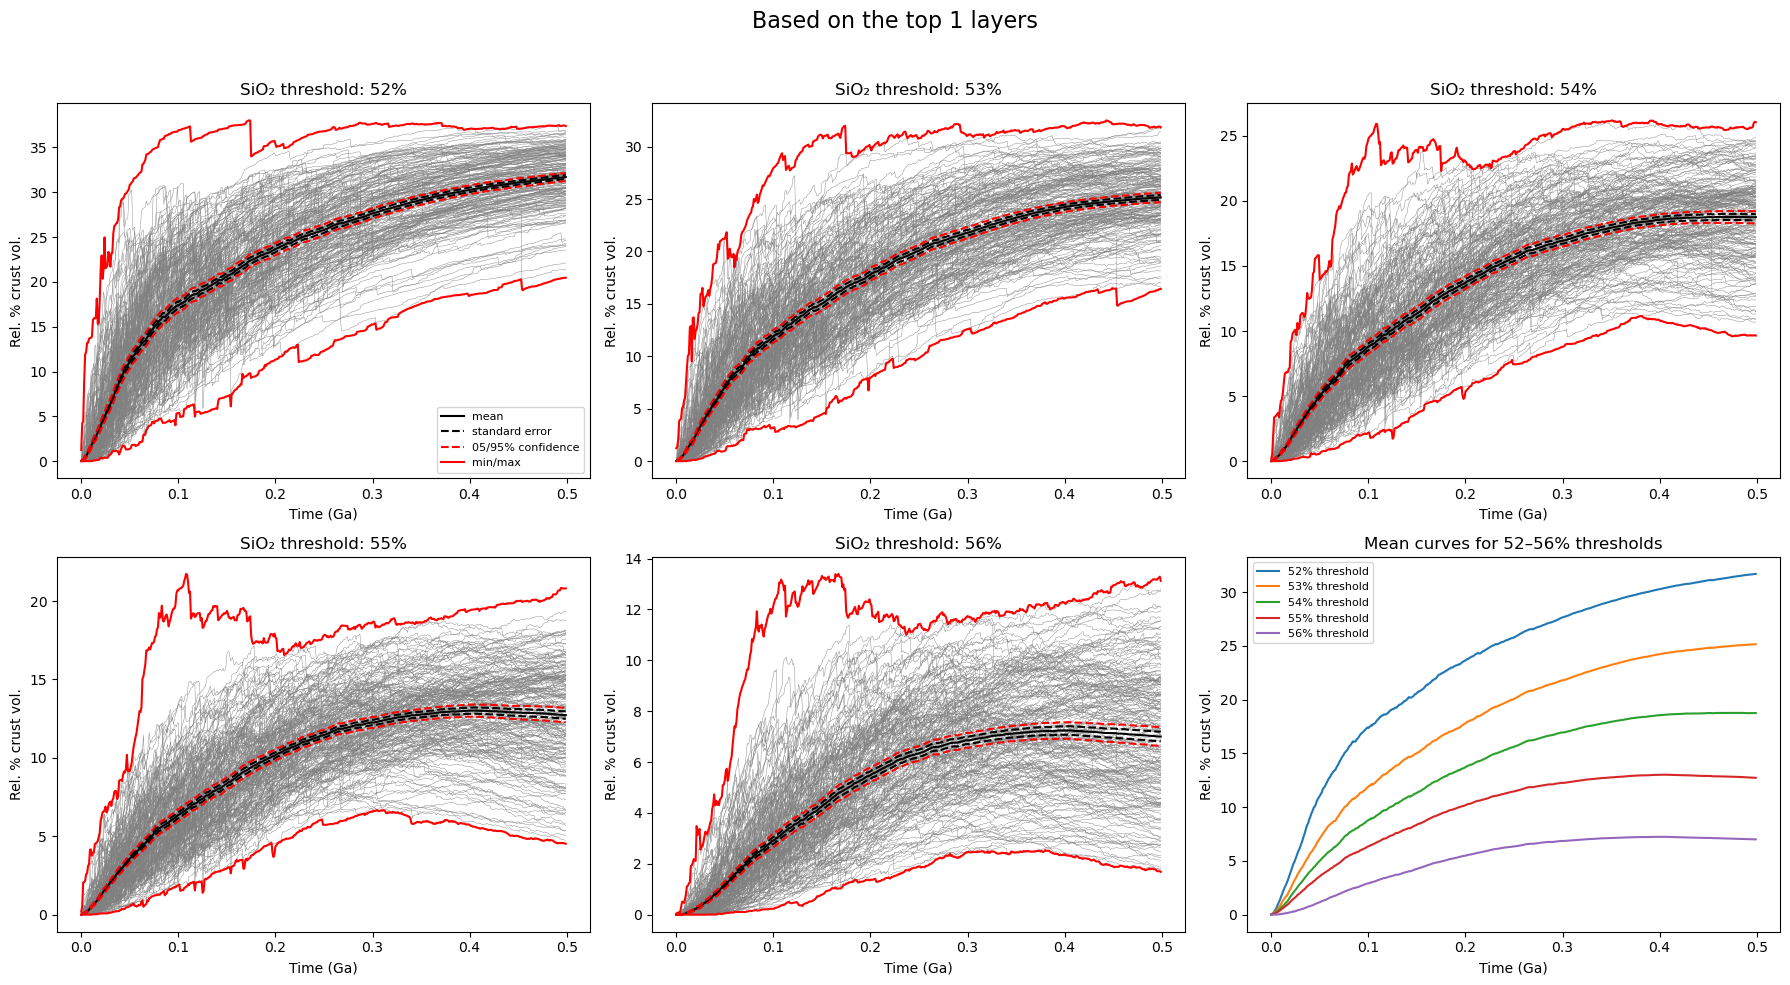

In [5]:
n_layers = 1
CRUST_THRESHOLDS = [52, 53, 54, 55, 56, 57]

# Equal weights for each layer
layer_weights = [1.0 / n_layers] * n_layers

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, CRUST_THRESHOLD in enumerate(CRUST_THRESHOLDS):
    if CRUST_THRESHOLD == 57:
        # Instead of plotting 57, overlay means for 52–56
        for thresh in [52, 53, 54, 55, 56]:
            crust_dict = {}
            for ensemble in ensembles:
                total = None
                for layer in range(n_layers):
                    percent_bins = [
                        str(p) for p in range(thresh, 101)
                        if str(p) in sio2_dict[ensemble][layer].columns
                    ]
                    df = sio2_dict[ensemble][layer][percent_bins].sum(axis=1)
                    weighted_df = layer_weights[layer] * df
                    total = weighted_df if total is None else total + weighted_df

                crust_dict[ensemble] = total * PERCENT_CURRENT_CONTINENTAL_CRUST

            crust_df = pd.DataFrame(crust_dict)
            crust_df['mean'] = crust_df.mean(axis=1)

            xvals = crust_df.index.values / 1000
            axes[i].plot(xvals, crust_df['mean'], label=f'{thresh}% threshold')

        axes[i].set_title("Mean curves for 52–56% thresholds")
        axes[i].set_xlabel("Time (Ga)")
        axes[i].set_ylabel("Rel. % crust vol.")
        axes[i].legend(fontsize=8)

    else:
        crust_dict = {}
        for ensemble in ensembles:
            # Plot individual ensemble members (top layer only for consistency)
            percent_bins_top = [
                str(p) for p in range(CRUST_THRESHOLD, 101)
                if str(p) in sio2_dict[ensemble][0].columns
            ]
            df_top = sio2_dict[ensemble][0][percent_bins_top].sum(axis=1) * PERCENT_CURRENT_CONTINENTAL_CRUST
            axes[i].plot(df_top.index.values / 1000, df_top.values, lw=0.3, c='grey',
                         label='ensemble member' if ensemble == 0 else None)

            # Weighted sum across layers
            total = None
            for layer in range(n_layers):
                percent_bins = [
                    str(p) for p in range(CRUST_THRESHOLD, 101)
                    if str(p) in sio2_dict[ensemble][layer].columns
                ]
                df = sio2_dict[ensemble][layer][percent_bins].sum(axis=1)
                weighted_df = layer_weights[layer] * df
                total = weighted_df if total is None else total + weighted_df

            crust_dict[ensemble] = total * PERCENT_CURRENT_CONTINENTAL_CRUST

        crust_df = pd.DataFrame(crust_dict)
        crust_df['mean'] = crust_df.mean(axis=1)
        crust_df['min'] = crust_df.min(axis=1)
        crust_df['max'] = crust_df.max(axis=1)
        crust_df['stdev'] = crust_df.std(axis=1)
        standard_error = crust_df['stdev'] / np.sqrt(len(ensembles))
        crust_df['e05'] = crust_df['mean'] - standard_error
        crust_df['e95'] = crust_df['mean'] + standard_error
        crust_df['c05'] = crust_df['mean'] - 1.96 * standard_error
        crust_df['c95'] = crust_df['mean'] + 1.96 * standard_error

        xvals = crust_df.index.values / 1000
        ax = axes[i]
        ax.plot(xvals, crust_df['mean'], c='k', label='mean')
        ax.plot(xvals, crust_df['e05'], '--', c='k', label='standard error')
        ax.plot(xvals, crust_df['e95'], '--', c='k')
        ax.plot(xvals, crust_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
        ax.plot(xvals, crust_df['c95'], '--', c='r')
        ax.plot(xvals, crust_df['min'].clip(lower=0), c='r', label='min/max')
        ax.plot(xvals, crust_df['max'], c='r')

        ax.set_title(f"SiO₂ threshold: {CRUST_THRESHOLD}%")
        ax.set_xlabel("Time (Ga)")
        ax.set_ylabel("Rel. % crust vol.")
        if i == 0:
            ax.legend(fontsize=8)

# Add overall title
fig.suptitle(f"Based on the top {n_layers} layers", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [24]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

n_layers = 1
CRUST_THRESHOLDS = list(range(52, 67))  # 52–66 inclusive
layer_weights = [1.0 / n_layers] * n_layers

fig, axes = plt.subplots(2, 1, figsize=(5, 8))

# ---------------------------------------------------------------------
# TOP SUBPLOT: detailed plot for 52% threshold
# ---------------------------------------------------------------------
crust_dict = {}
CRUST_THRESHOLD = 52

for ensemble in ensembles:
    percent_bins_top = [
        str(p) for p in range(CRUST_THRESHOLD, 101)
        if str(p) in sio2_dict[ensemble][0].columns
    ]
    df_top = sio2_dict[ensemble][0][percent_bins_top].sum(axis=1) * PERCENT_CURRENT_CONTINENTAL_CRUST
    axes[0].plot(df_top.index.values / 1000, df_top.values, lw=0.3, c='grey',
                 label='ensemble member' if ensemble == 0 else None)

    total = None
    for layer in range(n_layers):
        percent_bins = [
            str(p) for p in range(CRUST_THRESHOLD, 101)
            if str(p) in sio2_dict[ensemble][layer].columns
        ]
        df = sio2_dict[ensemble][layer][percent_bins].sum(axis=1)
        weighted_df = layer_weights[layer] * df
        total = weighted_df if total is None else total + weighted_df

    crust_dict[ensemble] = total * PERCENT_CURRENT_CONTINENTAL_CRUST

crust_df = pd.DataFrame(crust_dict)
crust_df['mean'] = crust_df.mean(axis=1)
crust_df['min'] = crust_df.min(axis=1)
crust_df['max'] = crust_df.max(axis=1)
crust_df['stdev'] = crust_df.std(axis=1)
standard_error = crust_df['stdev'] / np.sqrt(len(ensembles))
crust_df['e05'] = crust_df['mean'] - standard_error
crust_df['e95'] = crust_df['mean'] + standard_error
crust_df['c05'] = crust_df['mean'] - 1.96 * standard_error
crust_df['c95'] = crust_df['mean'] + 1.96 * standard_error

xvals = crust_df.index.values / 1000
ax = axes[0]
ax.plot(xvals, crust_df['mean'], c='k', label='mean')
ax.plot(xvals, crust_df['e05'], '--', c='k', label='standard error')
ax.plot(xvals, crust_df['e95'], '--', c='k')
ax.plot(xvals, crust_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
ax.plot(xvals, crust_df['c95'], '--', c='r')
ax.plot(xvals, crust_df['min'].clip(lower=0), c='r', label='min/max')
ax.plot(xvals, crust_df['max'], c='r')
ax.set_title("Detailed: SiO₂ threshold 52%")
ax.set_xlabel("Time (Ga)")
ax.set_ylabel("Rel. % crust vol.")
ax.legend(fontsize=8)

# ---------------------------------------------------------------------
# BOTTOM SUBPLOT: overlay mean curves for 52–66 thresholds with colormap
# ---------------------------------------------------------------------
cmap = cm.get_cmap("viridis")
norm = mcolors.Normalize(vmin=min(CRUST_THRESHOLDS), vmax=max(CRUST_THRESHOLDS))

for thresh in CRUST_THRESHOLDS:
    crust_dict = {}
    for ensemble in ensembles:
        total = None
        for layer in range(n_layers):
            percent_bins = [
                str(p) for p in range(thresh, 101)
                if str(p) in sio2_dict[ensemble][layer].columns
            ]
            df = sio2_dict[ensemble][layer][percent_bins].sum(axis=1)
            weighted_df = layer_weights[layer] * df
            total = weighted_df if total is None else total + weighted_df

        crust_dict[ensemble] = total * PERCENT_CURRENT_CONTINENTAL_CRUST

    crust_df = pd.DataFrame(crust_dict)
    crust_df['mean'] = crust_df.mean(axis=1)

    xvals = crust_df.index.values / 1000
    color = cmap(norm(thresh))
    axes[1].plot(xvals, crust_df['mean'], color=color, label=f'{thresh}%')

# add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1], orientation='vertical')
cbar.set_label("SiO₂ threshold (%)")

axes[1].set_title("Mean curves for thresholds 52–66%")
axes[1].set_xlabel("Time (Ga)")
axes[1].set_ylabel("Rel. % crust vol.")

# ---------------------------------------------------------------------
#fig.suptitle(f"Based on the top 2km", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("relative_crust_vol_time_52_thresh_all.png", dpi=300)
plt.close()

/var/folders/08/fcnqv5n16bd3p26sxm806b080000gp/T/ipykernel_17741/3147686793.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


In [7]:
final_values = {summary_characteristic:[] for summary_characteristic in ['mean', 'min', 'max',
                                                                         'standard_error', 'CI95']}
for i in range(3,len(ensembles)+1):
    crust_dict = {}
    for ensemble in ensembles[:i]:
        percent_bins=[]
        for p in range(CRUST_THRESHOLD,100):
            if str(p) in list(sio2_dict[ensemble][0].columns.values):
                percent_bins.append(str(p))
        df = 100* sio2_dict[ensemble][0].loc[:,percent_bins].sum(axis=1) / 40
        crust_dict[ensemble] = df.values
    crust_df = pd.DataFrame(crust_dict, index=df.index.values)
    crust_mean = crust_df.mean(axis=1)
    crust_df['mean'] = crust_df.mean(axis=1)
    crust_df['min'] = crust_df.min(axis=1)
    crust_df['max'] = crust_df.max(axis=1)
    crust_df['stdev'] = crust_df.std(axis=1)
    standard_error = crust_df['stdev']/np.sqrt(len(ensembles))
    crust_df['e05'] = crust_df['mean'] - standard_error
    crust_df['e95'] = crust_df['mean'] + standard_error
    crust_df['c95'] = crust_df['mean'] + standard_error * 1.96
    crust_df['c05'] = crust_df['mean'] - standard_error * 1.96
    final_values['mean'].append(crust_df['mean'][499])
    final_values['min'].append(crust_df['min'][499])
    final_values['max'].append(crust_df['max'][499])
    final_values['standard_error'].append(standard_error[499])
    final_values['CI95'].append(standard_error[499] * 1.96)

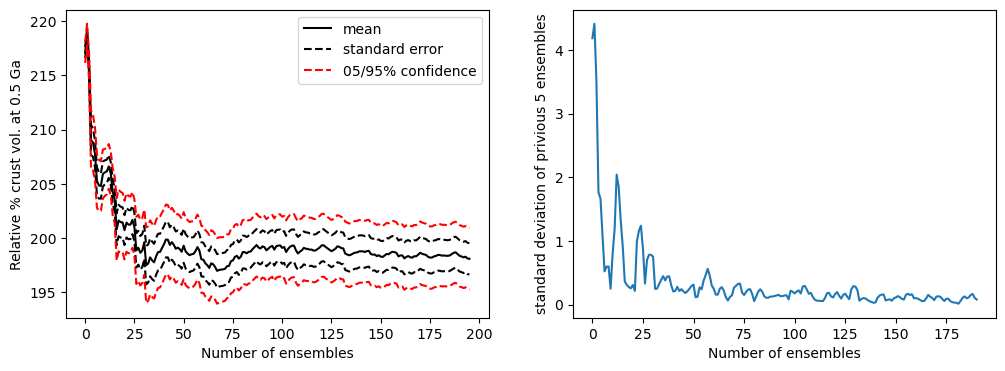

In [8]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)    
ax.plot(final_values['mean'], c='k', label='mean')
ax.plot(np.array(final_values['mean'])+np.array(final_values['standard_error']), 
         '--', c='k', label='standard error')
ax.plot(np.array(final_values['mean'])-np.array(final_values['standard_error']),'--', c='k', )
ax.plot(np.array(final_values['mean'])+np.array(final_values['CI95']), 
         '--', c='r', label='05/95% confidence')
ax.plot(np.array(final_values['mean'])-np.array(final_values['CI95']),'--', c='r', )
ax.set_xlabel("Number of ensembles")
ax.set_ylabel("Relative % crust vol. at 0.5 Ga")
plt.legend()

std_last_5_ens = []
for i in range(5,len(final_values['mean'])):
    std_last_5_ens.append(np.std(final_values['mean'][i-5:i]))
ax = fig.add_subplot(1, 2, 2)
ax.plot(std_last_5_ens)
ax.set_xlabel("Number of ensembles")
ax.set_ylabel("standard deviation of privious 5 ensembles")
# plt.savefig('./figs/paper_figs/ensemble_convergence_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/ensemble_convergence_bound.png', dpi=600)
plt.show()
plt.close()

In [9]:
total_impact_dict = {}
total_impact_dict['low'] = n_impact_dict[ensemble].low
total_impact_dict['high'] = n_impact_dict[ensemble].high
for ensemble in ensembles:
    total_impact_dict[ensemble] = n_impact_dict[ensemble].total

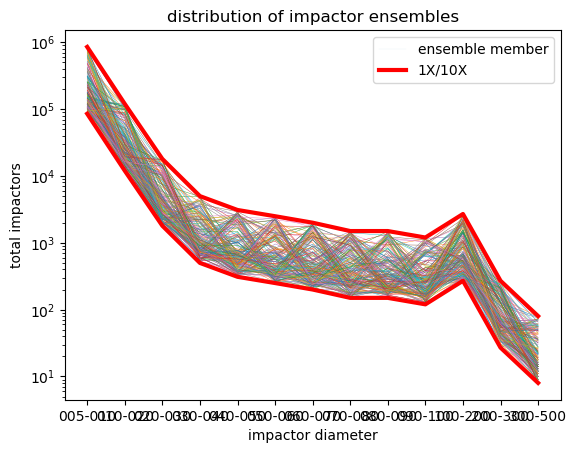

In [10]:
for ensemble in ensembles:
    if ensemble == 1:
        plt.plot(total_impact_dict[ensemble], lw=0.03, label="ensemble member")
    else:
        plt.plot(total_impact_dict[ensemble], lw=0.3)
plt.plot(n_impact_dict[1]['Unnamed: 0'], total_impact_dict['low'], c='r', lw=3, label='1X/10X')
plt.plot(n_impact_dict[1]['Unnamed: 0'], total_impact_dict['high'], c='r', lw=3)
plt.ylabel('total impactors')
plt.yscale('log')
plt.xlabel("impactor diameter")
plt.title("distribution of impactor ensembles")
plt.legend()
# plt.savefig('./figs/paper_figs/total_impacts_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/total_impacts_bound.png', dpi=600)
plt.show()
plt.close()

In [11]:
max_sio2_list={layer:{} for layer in range(12)}
for layer in range(11):
    for ensemble in ensembles:
        max_sio2_list[layer][ensemble]=[]
        for irow in sio2_dict[ensemble][layer].index.values:
            max_sio2_percent=0
            for icol in sio2_dict[ensemble][layer].columns.values[1:]:
                if sio2_dict[ensemble][layer].loc[irow,icol] > 0:
                    if int(icol) > max_sio2_percent:
                        max_sio2_percent = int(icol)
            max_sio2_list[layer][ensemble].append(max_sio2_percent)

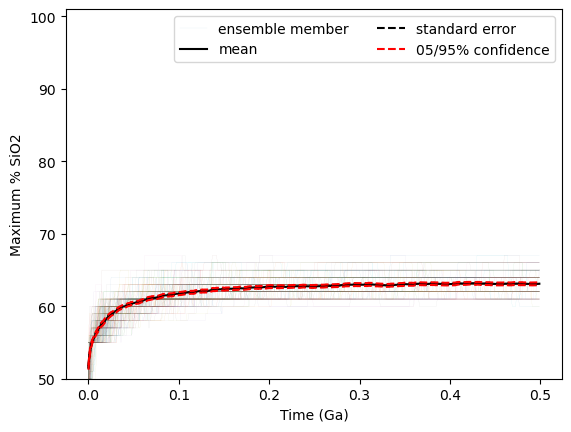

In [12]:
max_sio2_df          = pd.DataFrame(max_sio2_list[0])
max_sio2_df['mean']  = max_sio2_df.mean(axis=1)
max_sio2_df['min']   = max_sio2_df.min(axis=1)
max_sio2_df['max']   = max_sio2_df.max(axis=1)
max_sio2_df['stdev'] = max_sio2_df.std(axis=1)
standard_error       = max_sio2_df['stdev']/np.sqrt(len(ensembles))
max_sio2_df['e05']   = max_sio2_df['mean'] - standard_error
max_sio2_df['e95']   = max_sio2_df['mean'] + standard_error
max_sio2_df['c95']   = max_sio2_df['mean'] + standard_error * 1.96
max_sio2_df['c05']   = max_sio2_df['mean'] - standard_error * 1.96
for ensemble in ensembles:
    if ensemble == 1:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_list[0][ensemble], 
                 lw=0.03, label="ensemble member")        
    else:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_list[0][ensemble], lw=0.03)

plt.plot(max_sio2_df.index.values/1000, max_sio2_df['mean'], c='k', label='mean')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['e05'], '--', c='k', label='standard error')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['e95'], '--', c='k')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['c95'], '--', c='r')
# plt.plot(max_sio2_df.index.values/1000, max_sio2_df['min'].clip(lower=0), c='r', label='min/max')
# plt.plot(max_sio2_df.index.values/1000, max_sio2_df['max'], c='r')
plt.xlabel("Time (Ga)")
plt.ylabel("Maximum % SiO2")
plt.ylim([50,101])
plt.legend(ncol=2)
# plt.savefig('./figs/paper_figs/max_sio2_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/max_sio2_bound.png', dpi=600)
plt.show()
plt.close()

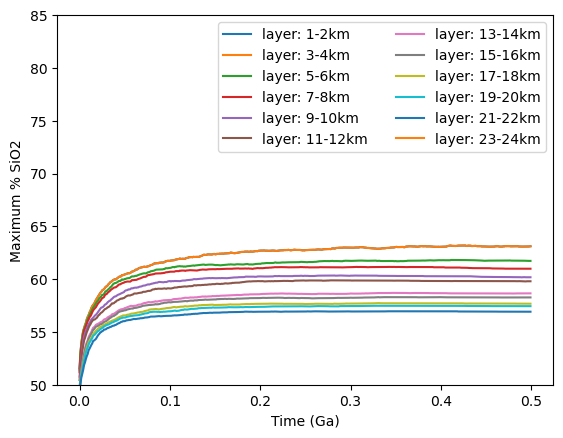

In [13]:
llyr = {0:"1-2km",1:"3-4km",2:"5-6km",3:"7-8km",4:"9-10km",5:"11-12km",
        6:"13-14km",7:"15-16km",8:"17-18km",9:"19-20km",10:"21-22km",11:"23-24km"}
for layer in range(12):
    max_sio2_df          = pd.DataFrame(max_sio2_list[layer])
    max_sio2_df['mean']  = max_sio2_df.mean(axis=1)
    plt.plot(max_sio2_df.index.values/1000, max_sio2_df['mean'], label=f'layer: {llyr[layer]}')
plt.xlabel("Time (Ga)")
plt.ylabel("Maximum % SiO2")
plt.ylim([50,85])
plt.legend(ncol=2)
# plt.savefig('./figs/paper_figs/max_sio2_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/max_sio2_bound.png', dpi=600)
plt.show()
plt.close()

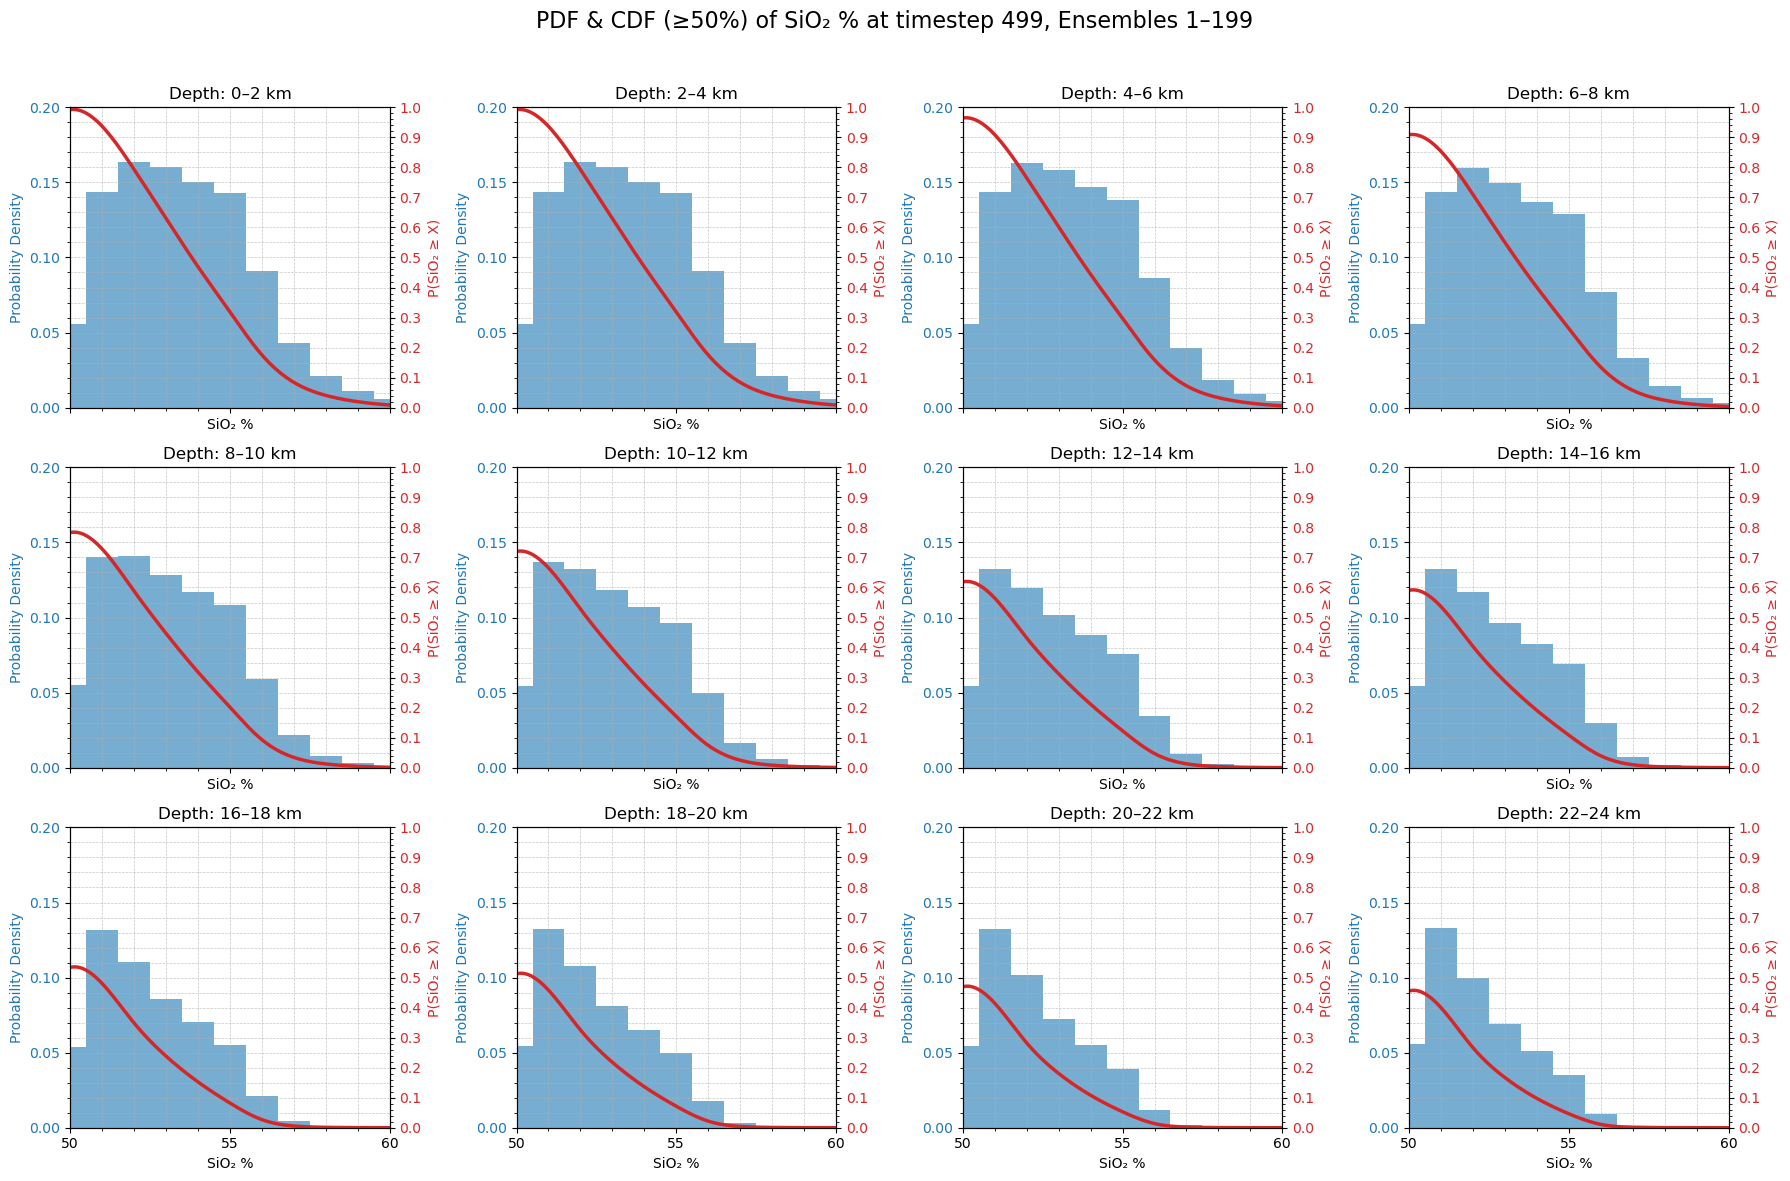

In [14]:
DATA_DIR = "../data/IMPaCS/sio2_percent_tables/july2025"
ENSEMBLES = range(1, 200)
LAYERS = range(0, 12)
FINAL_TIMESTEP = 499

def load_pdf_for_layer(layer):
    all_bins = set()
    pdfs = []
    for e in ENSEMBLES:
        path = os.path.join(DATA_DIR, f"ensemble_{e}_{layer}.csv")
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, index_col=0)
        if FINAL_TIMESTEP not in df.index:
            continue
        row = df.loc[FINAL_TIMESTEP].dropna()
        try:
            bins = np.array([int(c) for c in row.index])
            values = row.values.astype(float)
        except ValueError:
            continue
        pdf = values / values.sum() if values.sum() > 0 else values
        pdfs.append((bins, pdf))
        all_bins.update(bins)

    if not pdfs:
        return np.array([]), np.array([])

    sorted_bins = np.array(sorted(all_bins))
    pdf_matrix = np.zeros((len(pdfs), len(sorted_bins)))
    for i, (bins, pdf) in enumerate(pdfs):
        idx_map = {b: j for j, b in enumerate(sorted_bins)}
        for b, p in zip(bins, pdf):
            pdf_matrix[i, idx_map[b]] = p
    mean_pdf = pdf_matrix.mean(axis=0)
    return sorted_bins, mean_pdf

def depth_label(layer, dz_km=2):
    start = layer * dz_km
    end = start + dz_km
    return f"{start}–{end} km"

def plot_pdf_cdf_combined():
    fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharex=True, sharey=False)
    axes = axes.flatten()

    for idx, layer in enumerate(LAYERS):
        bins, mean_pdf = load_pdf_for_layer(layer)
        if bins.size == 0:
            continue

        # CDF for ≥50% only
        mask_50 = bins >= 50
        pdf_for_cdf = np.where(mask_50, mean_pdf, 0.0)
        cdf_rev = np.cumsum(pdf_for_cdf[::-1])[::-1]

        # Smooth CDF on the ≥50% domain
        bins_cdf = bins[mask_50]
        cdf_vals = cdf_rev[mask_50]
        if len(bins_cdf) > 3:
            spline = make_interp_spline(bins_cdf, cdf_vals, k=3)
            bins_smooth = np.linspace(bins_cdf.min(), bins_cdf.max(), 200)
            cdf_smooth = spline(bins_smooth)
        else:
            bins_smooth, cdf_smooth = bins_cdf, cdf_vals

        ax = axes[idx]
        ax2 = ax.twinx()

        # PDF (full range)
        ax.bar(bins, mean_pdf, width=1.0, align='center', alpha=0.6, color='tab:blue', label="PDF")
        ax.set_ylabel("Probability Density", color='tab:blue')
        ax.tick_params(axis='y', labelcolor='tab:blue')

        # CDF (≥50%), thicker & smooth
        ax2.plot(bins_smooth, cdf_smooth, color='tab:red', linewidth=2.5, label="CDF (≥50%)")
        ax2.set_ylabel("P(SiO₂ ≥ X)", color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # Grid & ticks (your settings)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        ax2.grid(False)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

        # Your y-limit for PDF
        ax.set_ylim([0, 0.2])
        ax2.set_ylim([0, 1])
        # Apply x-limits per-axes so it propagates with sharex
        ax.set_xlim(50, 60)

        # Title as depth range
        ax.set_title(f"Depth: {depth_label(layer)}")

        ax.set_xlabel("SiO₂ %")

    fig.suptitle(f"PDF & CDF (≥50%) of SiO₂ % at timestep {FINAL_TIMESTEP}, Ensembles 1–199", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Run
plot_pdf_cdf_combined()

In [23]:
# --- add this near your constants ---
DZ_KM = 2  # layer thickness used by depth_label
DEPTH_GROUPS = [(0, 4), (4, 8), (8, 12), (12, 16)]  # km

def layers_for_depth_range(start_km, end_km, dz_km=DZ_KM):
    start_layer = start_km // dz_km
    count = (end_km - start_km) // dz_km
    return list(range(start_layer, start_layer + count))

def load_pdf_for_layers(layer_list):
    """
    Combine mean PDFs from multiple layers:
    - call load_pdf_for_layer(layer) for each layer
    - align all bin grids to a union
    - average the PDFs across layers
    Returns (bins, mean_pdf_across_layers)
    """
    layer_pdfs = []
    all_bins = set()
    for layer in layer_list:
        bins, pdf = load_pdf_for_layer(layer)
        if bins.size == 0:
            continue
        layer_pdfs.append((bins, pdf))
        all_bins.update(bins.tolist())

    if not layer_pdfs:
        return np.array([]), np.array([])

    bins_all = np.array(sorted(all_bins))
    stacked = []
    idx_map = {b: i for i, b in enumerate(bins_all)}
    for bins, pdf in layer_pdfs:
        row = np.zeros_like(bins_all, dtype=float)
        for b, p in zip(bins, pdf):
            row[idx_map[b]] = p
        stacked.append(row)

    mean_pdf = np.vstack(stacked).mean(axis=0)
    # re-normalize just in case small numerical drift
    s = mean_pdf.sum()
    if s > 0:
        mean_pdf = mean_pdf / s
    return bins_all, mean_pdf

def depth_label_range(start_km, end_km):
    return f"{start_km}–{end_km} km"

# --- new plotting function for the four bands ---
def plot_pdf_cdf_4bands():
    fig, axes = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=False)
    axes = axes.flatten()

    for ax_idx, (start_km, end_km) in enumerate(DEPTH_GROUPS):
        ax = axes[ax_idx]
        layers = layers_for_depth_range(start_km, end_km, DZ_KM)
        bins, mean_pdf = load_pdf_for_layers(layers)
        if bins.size == 0:
            ax.set_title(f"Depth: {depth_label_range(start_km, end_km)} (no data)")
            ax.set_axis_off()
            continue

        # CDF for ≥50% only
        mask_50 = bins >= 50
        pdf_for_cdf = np.where(mask_50, mean_pdf, 0.0)
        cdf_rev = np.cumsum(pdf_for_cdf[::-1])[::-1]

        bins_cdf = bins[mask_50]
        cdf_vals = cdf_rev[mask_50]
        if len(bins_cdf) > 3:
            spline = make_interp_spline(bins_cdf, cdf_vals, k=3)
            bins_smooth = np.linspace(bins_cdf.min(), bins_cdf.max(), 200)
            cdf_smooth = spline(bins_smooth)
        else:
            bins_smooth, cdf_smooth = bins_cdf, cdf_vals

        ax2 = ax.twinx()

        # PDF
        ax.bar(bins, mean_pdf, width=1.0, align='center', alpha=0.6, label="PDF")
        ax.set_ylabel("Probability Density", color='tab:blue')
        ax.tick_params(axis='y', labelcolor='tab:blue')

        # CDF (≥50%)
        ax2.plot(bins_smooth, cdf_smooth, color='tab:red', linewidth=2.2, label="CDF (≥50%)")
        ax2.set_ylabel("P(SiO2 ≥ X)", color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # Grid & ticks
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        ax2.grid(False)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

        ax.set_ylim([0, 0.2])
        ax2.set_ylim([0, 1])
        ax.set_xlim(50, 60)

        ax.set_title(f"Depth: {depth_label_range(start_km, end_km)}")
        ax.set_xlabel("SiO2 %")

#    fig.suptitle(f"PDF & CDF of SiO2 % after 500Ma", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    plt.savefig("./figs/impaacs_pdf_cdf.png", dpi=300)
    plt.close()

# call the new plot
plot_pdf_cdf_4bands()